In [1]:
from utilsADCN import mnistLoader, plotPerformance
import numpy as np
import pdb
import torch
import random
from torchvision import datasets, transforms
import pickle

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.autograd.variable import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
num_workers = 0
from sklearn.cluster import KMeans, MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
import mnist_vae
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
import gc
torch.cuda.empty_cache()

cuda


In [2]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [3]:
seed = 216

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)  
random.seed(seed)  
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
start = time.time()


In [4]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load the training and test datasets
labeledData   = datasets.MNIST(root='data', train=False,download=True, transform=transform)
unlabeledData = datasets.MNIST(root='data', train=True, download=True, transform=transform)

In [5]:
## Load data
dataStream = mnistLoader(labeledData, unlabeledData, nEachClassSamples = 500)

Number of output:  10
Number of labeled data:  5000
Number of unlabeled data:  65000
Number of unlabeled data batch:  65


In [6]:
### Create the datastream
dataStream.createTask(nTask = 4)

Number of task:  4
Number of labeled data per task:  1250
Number of unlabeled data per task:  15000
Number of unlabeled data batch per task:  15
Number of unlabeled data test:  4000


In [7]:
dataStream.unlabeledData[3][1].shape

torch.Size([1, 28, 28])

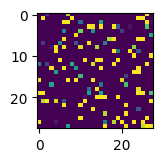

In [8]:
X = torch.transpose(dataStream.unlabeledData[1],1,2)
X = torch.transpose(X,2,3)
plt.figure(figsize= (1.5, 1.5))
plt.imshow(X[9887])

#### Train 

In [9]:
### Dataloader for different tasks
def trn_loader(task_id,batch_size):
  # task_id = 0
  x_samples = dataStream.unlabeledData[task_id].to(torch.float32)
  y_samples = dataStream.unlabeledLabel[task_id].to(torch.uint8)

  train_data = TensorDataset(x_samples,y_samples)
  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)

  return train_loader, train_data

In [10]:
def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    # print(confusion_matrix(ytrue, ypred))
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.prod(tp_rate)**(1/cm.shape[0])
    return ACSA, GM

#### VAE

In [11]:
## Loss function
def s_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    w_loss = x.mean() -x_hat.mean() #mean(x,x_hat) # K.mean(y_true * y_pred)
    beta = 1.2

    return reproduction_loss + beta*KLD + w_loss


In [12]:
## Train VAE
def vae_train(train_loader, model,optimzr,epochs,batchSize,x_dim):
  # Training

  model.train()
  for epoch in range(epochs):
      train_loss = 0
      for batch_idx, (x, _) in enumerate(train_loader):
          x = x.view(batchSize, x_dim)
          x = x.to(DEVICE)
          x_hat, mean, log_var = model(x)
          loss = s_loss_function(x, x_hat, mean, log_var)

          train_loss += loss.item()
          loss.backward()
          optimzr.step()
          optimzr.zero_grad()
      print("\tEpoch", epoch + 1, "complete!", "\tTraining Loss: ", train_loss / (batch_idx*batchSize),)
  return model

In [13]:
## Convert to low dimensional latent data
def latent_data(trn_load_ful,model,x_dim,btch_ful):
  for batch_idx, (x_ful, y_ful) in enumerate(trn_load_ful):
    x_ful = x_ful.view(btch_ful,x_dim)
    x_ful = x_ful.to(DEVICE)
    y_ful = y_ful.to(DEVICE)
  print(x_ful.shape)

  model.eval()
  x_out, z_mean_vae, _ = model(x_ful)
  return x_ful, y_ful, x_out, z_mean_vae

In [14]:
#### Structure of latent data capturing
def structure_data(real_data):

  P_cov = torch.cov(real_data, correction=0)
  D, V = torch.linalg.eigh(P_cov)
  idx = torch.argsort(D, dim=0,descending = True)
  d = D[idx]
  V = V[:,idx]
  
  return d, V

In [15]:
### Mapping k-means clusters to class labels
def asgn_clust_labl(km, tr_lbls):
    asgn_lbls = {}

    for i in range(km.n_clusters):

        lbls = []
        idx = np.where(km.labels_ == i)
        lbls.append(tr_lbls[idx])

        if (len(lbls[0]) == 1):
            cnts = np.bincount(lbls[0])
        else:
            cnts = np.bincount(np.squeeze(lbls))

        if np.argmax(cnts) in asgn_lbls:
            asgn_lbls[np.argmax(cnts)].append(i)
        else:
            asgn_lbls[np.argmax(cnts)] = [i]

    return asgn_lbls

def data_lbls(X_lbls, clust_lbls):

    p_lbls = np.zeros(len(X_lbls)).astype(np.uint8)

    for i, clus in enumerate(X_lbls):
        for key,value in clust_lbls.items():
            if clus in value:
                p_lbls[i] = key

    return p_lbls


In [16]:
# z_Ftrans.shape

In [17]:
## Training the experts 

task_id = 0
# VAE Model Hyperparameters
# batch_size = 100

inputdim = dataStream.unlabeledData[0].shape[2]*dataStream.unlabeledData[0].shape[3]
hiddendim1 = 650
hiddendim2 = 300
latent_dim = [64,64, 64,64,]
tot_clust = 600      
lr = [2e-4,2e-4,2e-4,2e-4,]
task_clust_lbls = {}
# epochs = 80
epch = [300, 300 , 300, 300 ]
s_encoder = mnist_vae.Encoder(input_dim =inputdim , hidden_dim1=hiddendim1, hidden_dim2=hiddendim2, latent_dim=latent_dim[task_id])
s_decoder = mnist_vae.Decoder(latent_dim=latent_dim[task_id], hidden_dim1=hiddendim1,hidden_dim2=hiddendim2, output_dim=inputdim)
s_task_model = mnist_vae.Model(Encoder=s_encoder, Decoder=s_decoder).to(DEVICE)
optimizer_VAE = Adam(s_task_model.parameters(), lr=lr[task_id])
batchsize = 1000 #dataStream.batchSize

# num1 = 20
cnt = 0


for task_id in range(4):

  print(task_id)
  data_loader, trn_data = trn_loader(task_id, batchsize)

  s_task_model = vae_train(data_loader,s_task_model,optimizer_VAE ,epch[task_id],batchsize,inputdim)
  torch.save(s_task_model.state_dict(),'s_task'+str(task_id)+'_model')


  for i in range(1):
    (x_lbl,y_lbl) = next(iter(data_loader))

  x_lbl = x_lbl.view(batchsize,inputdim)
  s_task_model.eval()
  _,z_lbl,_ = s_task_model(x_lbl.to(DEVICE))
  batch_ful = 7000
  # dataStream.unlabeledData[0].shape[0]
  train_loader_ful = DataLoader(dataset=trn_data, batch_size=batch_ful, shuffle=True, drop_last=True, num_workers=num_workers)
  x_ful, y_ful, x_out, z_mean_vae = latent_data(train_loader_ful,s_task_model,inputdim,batch_ful)

  X = z_mean_vae.cpu().detach().numpy()

  clust_lbl =  torch.unique(y_lbl).detach().numpy()
  n_clust = len(clust_lbl)

  if task_id ==0 :
    z_mn = {} 
    z_EVal = {} 
    z_EVec = {} 
  
  init_cntroid = torch.zeros((n_clust, latent_dim[task_id]))

  for num_clust in range(n_clust):
    init_cntroid[num_clust,:] = torch.mean(z_lbl[y_lbl == clust_lbl[num_clust]],0)

  init_cntroid = init_cntroid.detach().numpy()
  #'k-means++'
  kmeans = KMeans(n_clusters=tot_clust, random_state=3, init = 'k-means++' , n_init="auto",max_iter=8000, tol=0.00002,  ).fit(z_lbl.cpu().detach().numpy())
  clus_lbls = asgn_clust_labl(kmeans, y_lbl.detach().numpy())
  task_clust_lbls[task_id] = clus_lbls

  for i in range(n_clust):
    zxmean =  torch.mean(z_lbl[y_lbl == clust_lbl[i]],0)
    eVal, eVec = structure_data(z_lbl[y_lbl == clust_lbl[i]].T)
    # if task_id == 0:
    z_mn[task_id*n_clust+i] = zxmean
    z_EVal[task_id*n_clust+i] = eVal
    z_EVec[task_id*n_clust+i] = eVec

  if task_id == 0:
    # tmodel0 = task_model
    filename = 'Spl0_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 1:
    # tmodel1 = task_model
    filename = 'Spl1_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 2:
    # tmodel2 = task_model
    filename = 'Spl2_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 3:
    # tmodel3 = task_model
    filename = 'Spl3_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))


0
	Epoch 1 complete! 	Training Loss:  542.9034174107143
	Epoch 2 complete! 	Training Loss:  370.7803125
	Epoch 3 complete! 	Training Loss:  257.1727633928571
	Epoch 4 complete! 	Training Loss:  233.99088169642857
	Epoch 5 complete! 	Training Loss:  227.52287388392858
	Epoch 6 complete! 	Training Loss:  224.59891741071428
	Epoch 7 complete! 	Training Loss:  222.51980691964286
	Epoch 8 complete! 	Training Loss:  220.95993191964286
	Epoch 9 complete! 	Training Loss:  219.37572544642856
	Epoch 10 complete! 	Training Loss:  217.65664620535713
	Epoch 11 complete! 	Training Loss:  215.67457700892857
	Epoch 12 complete! 	Training Loss:  213.48030133928572
	Epoch 13 complete! 	Training Loss:  211.76489508928572
	Epoch 14 complete! 	Training Loss:  210.44920758928572
	Epoch 15 complete! 	Training Loss:  209.47683035714286
	Epoch 16 complete! 	Training Loss:  208.73466294642859
	Epoch 17 complete! 	Training Loss:  207.68139174107142
	Epoch 18 complete! 	Training Loss:  206.37354129464285
	Epoch 1

In [18]:
tsk_count = 4
arr_cnt = len(z_mn)

sample_size = 125 # Sample size for the structured data

# struct_samp_arr = torch.zeros((arr_cnt*sample_size,inputdim))
struct_samp_arr = torch.zeros((arr_cnt*sample_size,dataStream.unlabeledData[0].shape[1],
                               dataStream.unlabeledData[0].shape[2],dataStream.unlabeledData[0].shape[3]))
tsk_arr = torch.zeros((arr_cnt*sample_size))
arr = torch.zeros((arr_cnt*sample_size,64))

In [19]:
### Structured data generation
for n_cnt in range (len(z_mn)):
  s_encoder = mnist_vae.Encoder(input_dim =inputdim , hidden_dim1=hiddendim1, hidden_dim2=hiddendim2,latent_dim=latent_dim[n_cnt//10])
  s_decoder = mnist_vae.Decoder(latent_dim=latent_dim[n_cnt//10],hidden_dim1=hiddendim1,hidden_dim2=hiddendim2, output_dim=inputdim)
  savd_model = mnist_vae.Model(Encoder=s_encoder, Decoder=s_decoder).to(DEVICE)
  # for c_cnt in range (2):
  std_vec = torch.randn(sample_size, latent_dim[n_cnt//10]).to(DEVICE) #torch.empty(sample_size, latent_dim).normal_(mean=0,std=1.0) #
  a_vec = torch.mul(std_vec,z_EVal[n_cnt])
  a_vec = torch.matmul(z_EVec[n_cnt],a_vec.T).T+z_mn[n_cnt][None,:]
  # cl1_vec_T1_0 = torch.matmul(std_vec.to(DEVICE),z_Ftrans[:,:,(n_cnt)])
  # cl1_vec_T1_0 = torch.add(cl1_vec_T1_0,z_mn[:,n_cnt][None,:])
  # print(n_cnt)
  
  savd_model.load_state_dict(torch.load('s_task'+str(n_cnt//10)+'_model'))
  savd_model = savd_model.to(DEVICE)
  struct_samp_arr[(sample_size)*(n_cnt):(sample_size)*(n_cnt+1),:,:,:] = savd_model.Decoder(a_vec).view(a_vec.shape[0],
                                                                                                       1,28,28)
  tsk_arr[n_cnt*sample_size:(n_cnt+1)*sample_size] = n_cnt//10
  arr[(sample_size)*(n_cnt):(sample_size)*(n_cnt+1),:] = a_vec

In [20]:
arr = arr.to(DEVICE)

In [21]:
struct_samp_arr.shape

torch.Size([5000, 1, 28, 28])

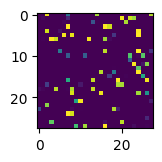

In [22]:

X = torch.reshape(struct_samp_arr,(5000,28,28))
plt.figure(figsize= (1.5, 1.5))
plt.imshow(X[228].detach().numpy())

#### Testing

In [23]:
cos = nn.CosineSimilarity(dim=1)

In [24]:
struct_samp_arr = struct_samp_arr.to(DEVICE)

In [25]:
c_vec = np.zeros((4,1))
tr_sum = 0
for task_id in range(0,4):
  Xtest1 = dataStream.labeledData[task_id].to(DEVICE)
  Xtest2 = Xtest1.view(Xtest1.shape[0],inputdim)
 
  ytest1 = dataStream.labeledLabel[task_id].to(DEVICE)
  s_encoder = mnist_vae.Encoder(input_dim =inputdim , hidden_dim1=hiddendim1, hidden_dim2=hiddendim2,latent_dim=latent_dim[task_id])
  s_decoder = mnist_vae.Decoder(latent_dim=latent_dim[task_id],hidden_dim1=hiddendim1,hidden_dim2=hiddendim2, output_dim=inputdim)
  savd_model = mnist_vae.Model(Encoder=s_encoder, Decoder=s_decoder).to(DEVICE)
  savd_model.load_state_dict(torch.load('s_task'+str(task_id)+'_model'))
  savd_model.eval()
  Xt_out,ZXtest1,_ = savd_model(Xtest2)
  for i in range(4):
    c_vec[i] = torch.sum(cos(struct_samp_arr[1250*i:1250*(i+1)].view(1250,784), Xt_out)).cpu().detach().numpy()

  arg_flg = np.argmax(c_vec)
  print('Selected Expert =', arg_flg)

  filename = 'Spl'+str(arg_flg)+'_clust_model.sav'
#   print(filename)
  kmn_model = pickle.load(open(filename, 'rb'))

  tst1_out = kmn_model.predict(ZXtest1.cpu().detach().numpy())
  pred_lbls = data_lbls(tst1_out, task_clust_lbls[arg_flg])

  tr_sum += np.trace(confusion_matrix(ytest1.cpu().detach().numpy(), pred_lbls))
  print(np.trace(confusion_matrix(ytest1.cpu().detach().numpy(), pred_lbls)))
end = time.time()
tr_sum /= 5000
print('Average accuracy=',tr_sum,)
print('Time taken =', (end-start), )




Selected Expert = 0
1088
Selected Expert = 1
1109
Selected Expert = 2
1100
Selected Expert = 3
1064
Average accuracy= 0.8722
Time taken = 305.52913880348206
